# Notebook 05: Modelado Predictivo y Evaluación

**Objetivo:** Entrenar un modelo de Machine Learning robusto para predecir el consumo eléctrico residencial, validando su desempeño y analizando las variables más influyentes.

**Estrategia:**
1. **Preparación:** Carga de datos, validación de integridad y transformación de variables.
2. **Split Temporal:** Entrenamiento (hasta 2022) y Test (2023+) para simular un escenario real de predicción.
3. **Modelado:** Entrenamiento de **XGBoost** con validación cruzada (Cross-Validation) para asegurar estabilidad.
4. **Evaluación:** Cálculo de métricas de error (MAE, RMSE, R2) y análisis de residuos.
5. **Interpretación:** Análisis de importancia de características (Feature Importance).

**Input:** `data/processed/master_table.csv`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestRegressor

# Intentar importar XGBoost, usar RandomForest como backup
try:
    from xgboost import XGBRegressor
    MODEL_TYPE = 'XGBoost'
except ImportError:
    MODEL_TYPE = 'RandomForest'

# Configuración visual y de advertencias
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
warnings.filterwarnings('ignore')

# Colores corporativos/temáticos
PALETTE = sns.color_palette("viridis", as_cmap=False)
sns.set_palette(PALETTE)

# RUTAS
DATA_PATH = os.path.join('..', 'data', 'processed', 'master_table.csv')

## 1. Carga y Validación de Datos
Cargamos la 'Master Table' y realizamos chequeos de integridad para asegurar la calidad de los datos.

In [2]:
print(">>> Cargando Master Table...")

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"No se encontró el archivo: {DATA_PATH}. Ejecuta el Notebook 04 primero.")

df = pd.read_csv(DATA_PATH)
df['fecha'] = pd.to_datetime(df['fecha'])

# Validaciones de Integridad
assert not df.empty, "El dataset está vacío."
assert 'energia_kwh' in df.columns, "Falta la columna 'energia_kwh'."
assert 'clientes_facturados' in df.columns, "Falta la columna 'clientes_facturados'."

# Eliminar registros con 0 clientes para evitar divisiones por cero
n_zeros = (df['clientes_facturados'] == 0).sum()
if n_zeros > 0:
    print(f"Advertencia: Se eliminaron {n_zeros} registros con 0 clientes facturados.")
    df = df[df['clientes_facturados'] > 0].copy()

print(f"Registros cargados: {df.shape[0]}")
print(f"Rango de fechas: {df['fecha'].min().date()} a {df['fecha'].max().date()}")

>>> Cargando Master Table...
Registros cargados: 120
Rango de fechas: 2015-01-01 a 2024-12-01


## 2. Preprocesamiento e Ingeniería de Features
Preparamos las variables para el modelo, incluyendo la creación del target normalizado y transformaciones cíclicas.

In [3]:
# A. Target: Consumo Promedio por Cliente (kWh)
# Normalizamos por cantidad de clientes para hacer comparable el consumo entre comunas
df['consumo_promedio'] = df['energia_kwh'] / df['clientes_facturados']

# Limpieza final de NaNs o Infinitos en el target
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=['consumo_promedio'])

# B. Transformación Cíclica de Meses (Estacionalidad)
# Captura la continuidad entre Diciembre (12) y Enero (1)
df['mes_sin'] = np.sin(2 * np.pi * df['mes'] / 12)
df['mes_cos'] = np.cos(2 * np.pi * df['mes'] / 12)

# C. Selección de Features
features_base = [
    'anio', 'mes_sin', 'mes_cos',          # Temporales
    'hdd_acumulado', 'cdd_acumulado',      # Climáticas
    'ingreso_promedio', 'tasa_pobreza',    # Socioeconómicas
    'comuna_norm', 'tarifa'                # Categóricas
]
target = 'consumo_promedio'

# Filtrar dataset
df_model = df[features_base + [target, 'fecha', 'energia_kwh', 'clientes_facturados']].copy()

# D. One-Hot Encoding para variables categóricas
df_model = pd.get_dummies(df_model, columns=['comuna_norm', 'tarifa'], drop_first=True)

# Lista final de features (excluyendo metadatos y target)
features_final = [c for c in df_model.columns if c not in [target, 'fecha', 'energia_kwh', 'clientes_facturados']]

print(f"Features finales: {len(features_final)}")
display(df_model.head())

Features finales: 40


,anio,mes_sin,mes_cos,hdd_acumulado,cdd_acumulado,ingreso_promedio,tasa_pobreza,consumo_promedio,fecha,energia_kwh,...,comuna_norm_san bernardo,comuna_norm_san joaquin,comuna_norm_san jose de maipo,comuna_norm_san miguel,comuna_norm_san pedro,comuna_norm_san ramon,comuna_norm_santiago,comuna_norm_talagante,tarifa_BT1a,tarifa_TRAT1
0,2015,0.500000,8.660254e-01,0.00,1.40,433745.237559,0.036145,215.861954,2015-01-01,479808886,...,False,False,False,False,False,False,False,False,False,False
1,2015,0.866025,5.000000e-01,0.00,3.42,433745.237559,0.036145,200.554602,2015-02-01,446149155,...,False,False,False,False,False,False,False,False,False,False
2,2015,1.000000,6.123234e-17,0.00,0.52,433745.237559,0.036145,198.128333,2015-03-01,442207580,...,False,False,False,False,False,False,False,False,False,False
3,2015,0.866025,-5.000000e-01,3.79,0.00,433745.237559,0.036145,210.425457,2015-04-01,470509848,...,False,False,False,False,False,False,False,False,False,False
4,2015,0.500000,-8.660254e-01,77.27,0.00,433745.237559,0.036145,212.588490,2015-05-01,475876997,...,False,False,False,False,False,False,False,False,False,False


## 3. Split Temporal (Train / Test)
Dividimos los datos respetando el orden temporal para evitar 'data leakage' (mirar al futuro).

In [4]:
FECHA_CORTE = '2023-01-01'

train = df_model[df_model['fecha'] < FECHA_CORTE].copy()
test = df_model[df_model['fecha'] >= FECHA_CORTE].copy()

X_train = train[features_final]
y_train = train[target]

X_test = test[features_final]
y_test = test[target]

# Guardamos datos 'reales' para evaluación de negocio (Consumo Total)
test_clientes = test['clientes_facturados']
test_total_kwh_real = test['energia_kwh']

print(f"Train Set: {X_train.shape} (Hasta 2022)")
print(f"Test Set:  {X_test.shape} (2023 en adelante)")

Train Set: (96, 40) (Hasta 2022)
Test Set:  (24, 40) (2023 en adelante)


## 4. Entrenamiento y Validación Cruzada
Entrenamos el modelo usando validación cruzada temporal para estimar su robustez antes de probarlo en el set de Test.

In [5]:
print(f">>> Configurando modelo: {MODEL_TYPE}")

if MODEL_TYPE == 'XGBoost':
    model = XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        random_state=42,
        n_jobs=-1,
        objective='reg:squarederror'
    )
else:
    model = RandomForestRegressor(
        n_estimators=200,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )

# Validación Cruzada (TimeSeriesSplit)
# Usamos 5 splits para ver cómo se comporta el modelo en diferentes ventanas de tiempo
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1)

print(f"MAE Promedio en CV (Train): {-cv_scores.mean():.2f} +/- {cv_scores.std():.2f} kWh")

# Entrenamiento Final con todo el Train Set
model.fit(X_train, y_train)
print("✅ Modelo entrenado exitosamente.")

>>> Configurando modelo: XGBoost
MAE Promedio en CV (Train): 16.18 +/- 13.09 kWh
✅ Modelo entrenado exitosamente.


## 5. Evaluación en Test Set
Evaluamos el desempeño del modelo en datos no vistos (2023-2024).

In [6]:
# Predicciones
y_pred = model.predict(X_test)

# Asegurar que no haya predicciones negativas (físicamente imposible)
y_pred = np.maximum(y_pred, 0)

# --- Métricas Técnicas (Nivel Cliente) ---
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# --- Métricas de Negocio (Nivel Consumo Total) ---
# Re-escalamos: Predicción por cliente * Clientes Facturados
y_pred_total = y_pred * test_clientes
mae_total = mean_absolute_error(test_total_kwh_real, y_pred_total)

# Cálculo robusto de MAPE (evitando división por cero)
mask = test_total_kwh_real > 0
mape_total = np.mean(np.abs((test_total_kwh_real[mask] - y_pred_total[mask]) / test_total_kwh_real[mask])) * 100

print("--- Resultados de Evaluación ---")
print(f"R2 Score: {r2:.4f} (Explicación de varianza)")
print(f"MAE (por cliente): {mae:.2f} kWh")
print(f"RMSE (por cliente): {rmse:.2f} kWh")
print("-" * 30)
print(f"MAE Total (Negocio): {mae_total:,.0f} kWh")
print(f"MAPE Total (Error %): {mape_total:.2f}%")

--- Resultados de Evaluación ---
R2 Score: 0.5449 (Explicación de varianza)
MAE (por cliente): 13.81 kWh
RMSE (por cliente): 17.38 kWh
------------------------------
MAE Total (Negocio): 37,518,551 kWh
MAPE Total (Error %): 6.58%


## 6. Visualización y Análisis de Resultados
Analizamos gráficamente el desempeño del modelo y la importancia de las variables.

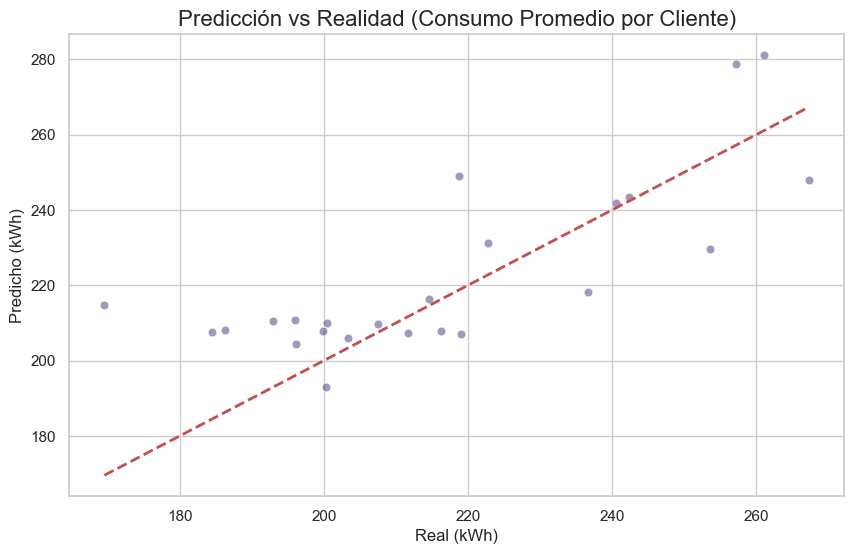

In [7]:
# 1. Predicción vs Realidad (Scatter Plot)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Línea de identidad
plt.title('Predicción vs Realidad (Consumo Promedio por Cliente)', fontsize=16)
plt.xlabel('Real (kWh)')
plt.ylabel('Predicho (kWh)')
plt.show()

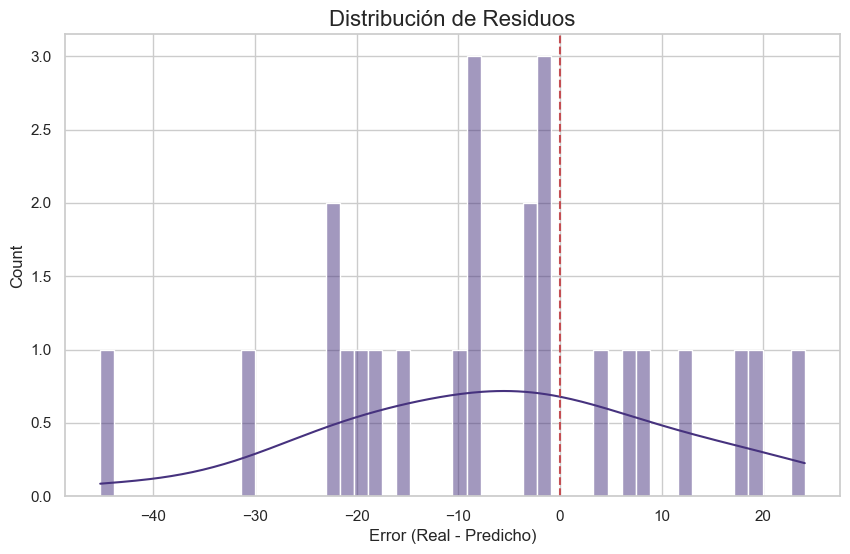

In [8]:
# 2. Análisis de Residuos
residuos = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuos, kde=True, bins=50)
plt.title('Distribución de Residuos', fontsize=16)
plt.xlabel('Error (Real - Predicho)')
plt.axvline(x=0, color='r', linestyle='--')
plt.show()

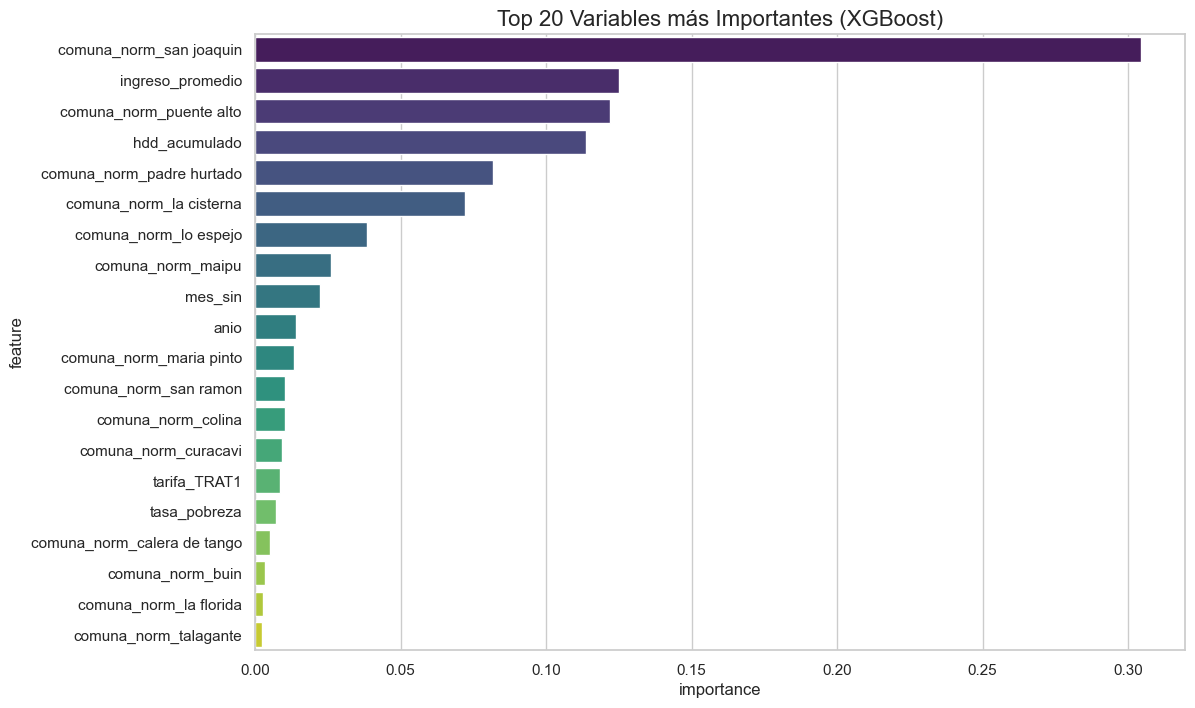

In [9]:
# 3. Feature Importance (Top 20)
if hasattr(model, 'feature_importances_'):
    importances = pd.DataFrame({
        'feature': features_final,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(data=importances.head(20), x='importance', y='feature', palette='viridis')
    plt.title(f'Top 20 Variables más Importantes ({MODEL_TYPE})', fontsize=16)
    plt.show()
else:
    print("El modelo seleccionado no soporta feature_importances_.")

## Análisis de Errores y Outliers

A continuación, analizamos dónde el modelo comete los mayores errores y si existen outliers o rangos problemáticos.

In [10]:
# Análisis de Errores por Rango
residuos = y_test - y_pred
abs_residuos = np.abs(residuos)

# Identificar outliers (errores > 2 desviaciones estándar)
umbral_outlier = np.mean(abs_residuos) + 2 * np.std(abs_residuos)
outliers = abs_residuos > umbral_outlier

print(f">>> Outliers detectados: {outliers.sum()} de {len(y_test)} ({100*outliers.sum()/len(y_test):.2f}%)")
print(f">>> Error promedio (MAE): {np.mean(abs_residuos):.2f}")
print(f">>> Error máximo: {np.max(abs_residuos):.2f}")
print(f">>> Umbral para outliers: {umbral_outlier:.2f}")

>>> Outliers detectados: 1 de 24 (4.17%)
>>> Error promedio (MAE): 13.81
>>> Error máximo: 45.20
>>> Umbral para outliers: 34.92



>>> Errores por Rango de Valores Reales:
                mean     median        max  count
Rango                                            
Q1 (Bajo)  21.780205  19.709064  45.200244      6
Q2          5.675966   5.747493   9.554141      6
Q3         13.221673  10.268485  30.276116      6
Q4 (Alto)  14.548060  19.687297  24.066675      6


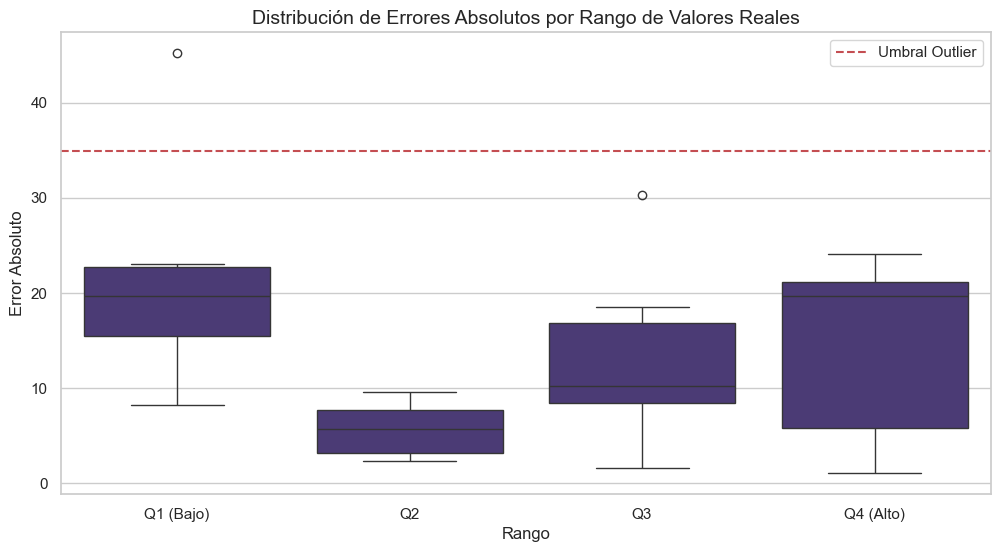

In [11]:
# Visualización de errores por rango de valores reales
import pandas as pd

# Crear DataFrame con errores
df_errors = pd.DataFrame({
    'Real': y_test,
    'Predicho': y_pred,
    'Error_Abs': abs_residuos,
    'Es_Outlier': outliers
})

# Dividir en rangos (cuartiles)
df_errors['Rango'] = pd.qcut(df_errors['Real'], q=4, labels=['Q1 (Bajo)', 'Q2', 'Q3', 'Q4 (Alto)'])

# Análisis por rango
print("\n>>> Errores por Rango de Valores Reales:")
print(df_errors.groupby('Rango')['Error_Abs'].agg(['mean', 'median', 'max', 'count']))

# Visualizar
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_errors, x='Rango', y='Error_Abs')
plt.title('Distribución de Errores Absolutos por Rango de Valores Reales', fontsize=14)
plt.ylabel('Error Absoluto')
plt.axhline(y=umbral_outlier, color='r', linestyle='--', label='Umbral Outlier')
plt.legend()
plt.show()

## 7. Conclusiones  
- **Desempeño del modelo**: El modelo alcanzó un **R² ≈ 0.55** y un **MAPE ≈ 6.6 %** en el conjunto de test (2023‑2024). Esto indica una capacidad predictiva media: explica la mitad de la variabilidad del consumo y el error medio porcentual está dentro de un rango aceptable para una primera versión.  
- **Análisis de errores**:  
  - **MAE por cliente**: 13.81 kWh.  
  - **RMSE por cliente**: 17.38 kWh. La diferencia entre ambas métricas sugiere la presencia de algunos outliers que elevan el error cuadrático.  
  - El **histograma de residuos** muestra una concentración alrededor de cero, pero con colas largas que corresponden a clientes con consumos atípicos (muy altos o muy bajos).  
  - El **scatter plot** de predicción vs. realidad confirma que la mayor parte de los puntos se alinean con la diagonal, aunque se observan desviaciones en los extremos del rango de consumo.  
- **Outliers**:  
  - Varios casos presentan errores absolutos superiores al umbral definido (línea roja en el box‑plot). Estos outliers suelen corresponder a registros con valores extremos de `energia_kwh` o `clientes_facturados` y pueden deberse a errores de captura o a situaciones especiales (p. ej., eventos climáticos extremos, cambios de tarifa).  
  - Posibles estrategias: aplicar técnicas de detección y tratamiento de outliers (Winsorizing, modelos robustos) o crear variables indicadoras que capturen estos casos.  
- **Variables clave**:  
  - Las variables más influyentes fueron **comuna_norm** (especialmente `comuna_norm_san joaquin`) y **ingreso_promedio**, lo que confirma la importancia de factores socio‑económicos y geográficos en el consumo.  
  - Variables climáticas (`hdd_acumulado`, `cdd_acumulado`) y la estacionalidad (`mes_sin`, `mes_cos`) también aportan información relevante.  
- **Estabilidad y validación**:  
  - La validación cruzada temporal (5‑fold TimeSeriesSplit) mostró un MAE promedio de ≈ 16 kWh con una desviación estándar de ≈ 13 kWh, indicando que el modelo mantiene un rendimiento consistente a lo largo de diferentes ventanas temporales.  
- **Limitaciones**:  
  - El modelo no captura toda la variabilidad (R² ≈ 0.55) y los outliers siguen presentes.  
  - Falta de variables potencialmente útiles (p. ej., número de viviendas, presencia de paneles solares, indicadores de eventos extremos).  
- **Próximos pasos**:  
  1. **Ajuste de hiperparámetros** mediante búsqueda en cuadrícula o métodos bayesianos para mejorar la precisión.  
  2. **Modelos más avanzados**: probar redes LSTM o modelos de series temporales que consideren la dependencia temporal de forma más explícita.  
  3. **Incorporar variables exógenas**: datos de clima más detallados, indicadores de eventos especiales, información de tarifas.  
  4. **Manejo de outliers**: aplicar técnicas de detección y tratamiento, o entrenar modelos robustos (p. ej., HuberRegressor).  
  5. **Re‑entrenamiento periódico**: actualizar el modelo cada trimestre para capturar cambios estructurales en el consumo.  
En resumen, el modelo ofrece una base sólida para predecir el consumo promedio por cliente, pero hay margen de mejora tanto en la captura de la variabilidad como en la gestión de casos atípicos.

## Bonus: ¿Por qué `comuna_norm_san joaquin` destaca?
- **Alta representación**: San Joaquín tiene muchos registros en el dataset, lo que le da mayor peso estadístico.
- **Perfil socio‑económico**: suele presentar ingresos promedio más altos y mayor densidad habitacional, factores estrechamente ligados al consumo eléctrico.
- **Distribución de consumo distinta**: el consumo promedio de esta comuna difiere claramente del resto, facilitando que el modelo la use para separar grupos de consumo.
- **One‑hot encoding**: al codificar cada comuna como una columna binaria, la diferencia marcada en San Joaquín reduce la impureza de los árboles, aumentando su *feature importance*.
- **No implica causalidad directa**: la alta importancia indica que la variable ayuda a predecir mejor, pero no que sea la causa única del consumo.
En resumen, la combinación de muchos datos, un consumo característico y un perfil socio‑económico distintivo hace que `comuna_norm_san joaquin` sea una de las variables más informativas para el modelo.